In [27]:
%matplotlib inline
from IPython.display import Video, HTML
from PIL import Image, ImageOps
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from vision import *


# Objective - Create a Classifier to Identify Cells

Firstly, visualize a still of the video (Video Source, Lund University : https://www.youtube.com/watch?v=ORBSW7G92Nc) to have a better sense of how the file should be manipulated to generate training data used to create the classifier. The objective is to automtically detect a cell so that it can be latter passed on to other ML models to predict additional properties of the cell.

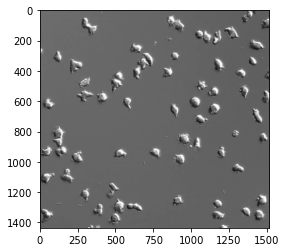

In [3]:
cv.startWindowThread()
cell_images = cv.imread("Photos/cells_still.png") # import screenshot of video
plt.imshow(cell_images) # Visualized with Matplotlib
plt.show()


While the following functions will not ultimately be used to detect the cells in the video, they can be used to help create a larger training set of data to improve the classifier. 

In [4]:
def rescaleFrame(frame, scale=0.75):
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    dimensions = (width,height)
        
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)
    
def changeRes(width,height):
    #Only works for live Video
    capture.set(3,width) # 3 references the width
    capture.set(4,height) # 4 references the height
    
#translation (up,down,left,right)
def translate(img, x, y):
    transMat = np.float32([[1,0,x],[0,1,y]])
    dimensions = (img.shape[1],img.shape[0])
    return cv.warpAffine(img, transMat, dimensions)

def rotate(img, angle, rotPoint=None):
    (height,width) = img.shape[:2]
    
    if rotPoint is None:
        rotPoint = (width//2,height//2)
        
    rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
    dimensions = (width,height)
    
    return cv.warpAffine(img, rotMat, dimensions)

#FLIP
flip = cv.flip(img,0) # 0 over x, 1 over y, -1 over x and y
cv.imshow("flipped",flip)

# Helps to kill pop-up at the end of cv.imshow()
def destroy_windows():
    blank = np.zeros((np.shape(img)[0],np.shape(img)[1],3),dtype='uint8')
    cv.waitKey(0)
    cv.destroyAllWindows()

## Other operations to manipulate the image.

#Load image
img = cv.imread('Photos/sclerenchyma_cells.jpeg')
#cv.imshow("color",img)

# #Convert to Grayscale
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# cv.imshow("gray",gray)

# #Blur
#blur = cv.GaussianBlur(img,(5,5),cv.BORDER_DEFAULT)
#cv.imshow("blur", blur)

#Edge Cascade
#canny = cv.Canny(img,125,175)
#canny = cv.Canny(blur,125,175)
#cv.imshow("Canny",canny)

#Dilating the image
dilated = cv.dilate(canny,(3,3), iterations=1)
cv.imshow("dilated",dilated)

# Eroding
eroded = cv.erode(dilated,(3,3),iterations=1)
cv.imshow("eroded",eroded)

# Resize an image
resized = cv.resize(img,(500,500),interpolation=cv.INTER_AREA)
cv.imshow("rsized", resized)

# Cropping
cropped = img[50:200,200:400]
cv.imshow('Cropped', cropped)

In [ ]:
#IDENTIFYING CONTOURS - For shape analysis
blank = np.zeros(img.shape[:2], dtype='uint8')
cv.imshow('blank',blank)

img = cv.imread('Photos/cells_still.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
cv.imshow("Gray",gray)

# blur = cv.GaussianBlur(gray,(5,5),cv.BORDER_DEFAULT)
# cv.imshow("blur",blur)

# canny = cv.Canny(blur,125,175)
# cv.imshow("Canny Edges", canny )

ret, thresh = cv.threshold(gray, 120, 255 , cv.THRESH_BINARY)
cv.imshow("threshold",thresh)


contours, hierarchies = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
print(f'{len(contours)} contour(s) found!')

cv.drawContours(img, contours, -1, (0,0,255), thickness=3)
cv.imshow("Img with Contours",img)

cv.waitKey(0)
cv.destroyAllWindows()
destroy_windows()


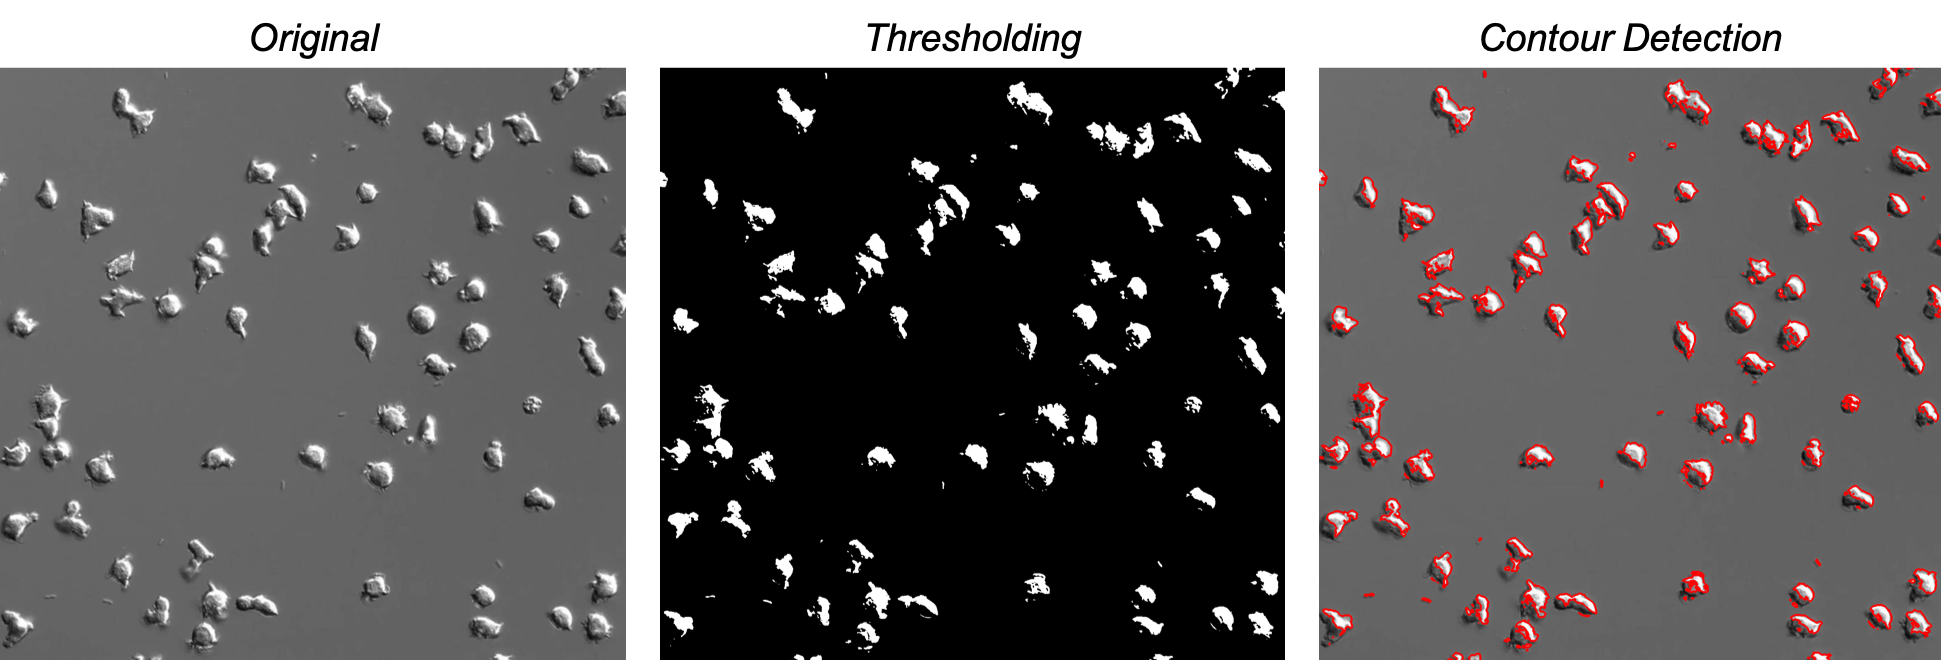



## Generating Training Data

Given the short amount of time to work on the classifier, as an initial training set, I have decided to take a sliding window (here of 120px by 120px) that scans the full image and saves the images automaticall into the Negative images. I then manually move those images with a full cell into the directory associated with the Positive images. Given further delevopment, I would create helper functions to more easily sort through the images for likely positive IDs which would then be verified more quickly. Moreover, a more robust training set would draw on frames throughout the entire video rather than t=0.

In [ ]:
img = cv.imread('Photos/cells_still.png') #example of frame used to create the training data.

width = int(img.shape[1])
height = int(img.shape[0])

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

slidingWindow = (120,120)

counter = 0

for x in np.arange(0,width-slidingWindow[0],slidingWindow[0]//4):
    for y in np.arange(0,height-slidingWindow[1],slidingWindow[1]//4):
        counter += 1
        crop = img[x:x+slidingWindow[0],y:y+slidingWindow[1]]
        cv.imwrite(r'TrainingData/noCells/cells_Frame'+str(counter).zfill(5)+'.png',crop)


Using the OpenCV Library, I created my own Haar cascade classifer to identify if there was a cell present or not. For future applications, for mixtures of different cells, I would train the classifier on all types of cells and then following this initial identification, pass the identified regions to additional ML models (e.g. CNN) for classification. The Harr cascade was only trained on 300 positive images and 150 negative images, so with a larger training set, I believe the model could have an even better identification rate.

In [15]:
# Load Cell Trained Model
cascade_cells = cv.CascadeClassifier('cascade/cell_haar.xml')


In [16]:
#Code for drawing rectangles was drawn from the Git of learncodebygaming at : https://github.com/learncodebygaming/opencv_tutorials/blob/master/008_cascade_classifier/vision.py
vision_cells = Vision(None)

Finally, this classifier can be used to analyze each frame of the original video from Lund University. A video file is written by drawing the regions identified as likely having a cell.

In [ ]:
#Video Source, Lund University : https://www.youtube.com/watch?v=ORBSW7G92Nc
capture = cv.VideoCapture("Videos/Lund_cells.mp4")

#Code used to visualize rectangles on the original image.
vision_cells = Vision(None)

frame_width = int(capture.get(3))
frame_height = int(capture.get(4))


out = cv.VideoWriter('tracking_cells.mp4',cv.VideoWriter_fourcc(*'mp4v'),10, (frame_width, frame_height))
 

while True:
    isTrue, frame = capture.read()
    rectangles = cascade_cells.detectMultiScale(frame)
    
    detection_image = vision_cells.draw_rectangles(frame, rectangles)
    
    out.write(detection_image)

    
    if cv.waitKey(20) & 0xFF==ord('q'):
        cv.destroyWindow('Video')
        break
        
capture.release()
out.release()
cv.destroyWindow('Video')
cv.destroyAllWindows()

<video controls src="./tracking_cells.mp4"> Output: Tracking Cells </video>

In [34]:
## If Embedding doesn't work in Jupyter, the .mp4 file can be found in the current directory.

Video(os.getcwd()+"/tracking_cells.mp4", embed=True)

From this initial exercise, I hope to demonstrate my ability to start from video source data, identify how to generate appropriate training data, create and improve classifiers for object detection and to handle resulting data to be passed to additional ML models.

While the model isn't perfect, for two days of work on a small, manually generated training set, I think the results are not bad. Improvements would come in expanding and improving the quality of the training set and systematically tuning the classifier to improve performance and avoid overfitting. Additional steps could be analyses of the movement of each cell's trajectory, interactions between the cells, shape analysis, etc.